<a href="https://colab.research.google.com/github/igormlynarczuk/PROD1_Project/blob/main/PROD1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######################################
# 1. IMPORT BIBLIOTEK
######################################
from imblearn.over_sampling import ADASYN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
######################################
# 2. WCZYTANIE I PRZYGOTOWANIE DANYCH
######################################
# Dane
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
    'restecg', 'thalach', 'exang', 'oldpeak',
    'slope', 'ca', 'thal', 'target'
]
data = pd.read_csv(url, header=None, names=columns, na_values='?')

# Usuwanie wierszy z brakującymi danymi
data.dropna(inplace=True)

# Krótka informacja o zbiorze
print("Rozkład wartości targetu (oryginalny):")
print(data['target'].value_counts())
print("\nPrzykładowe wiersze:\n", data.head())

# Klasyfikacja binarna (chore/zdrowe)
X = data.drop('target', axis=1)
y_bin = (data['target'] > 0).astype(int)  # 1 = chore, 0 = zdrowe

# Klasyfikacja wieloklasowa (stadium: 0–4)
y_multi = data['target']

Rozkład wartości targetu (oryginalny):
target
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64

Przykładowe wiersze:
     age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


In [ ]:
######################################
# 3. PODZIAŁ NA ZBIÓR TRENINGOWY I TESTOWY
######################################
# BINARNIE
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)

# WIELOKLASOWO (0–4)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.25, random_state=42, stratify=y_multi
)



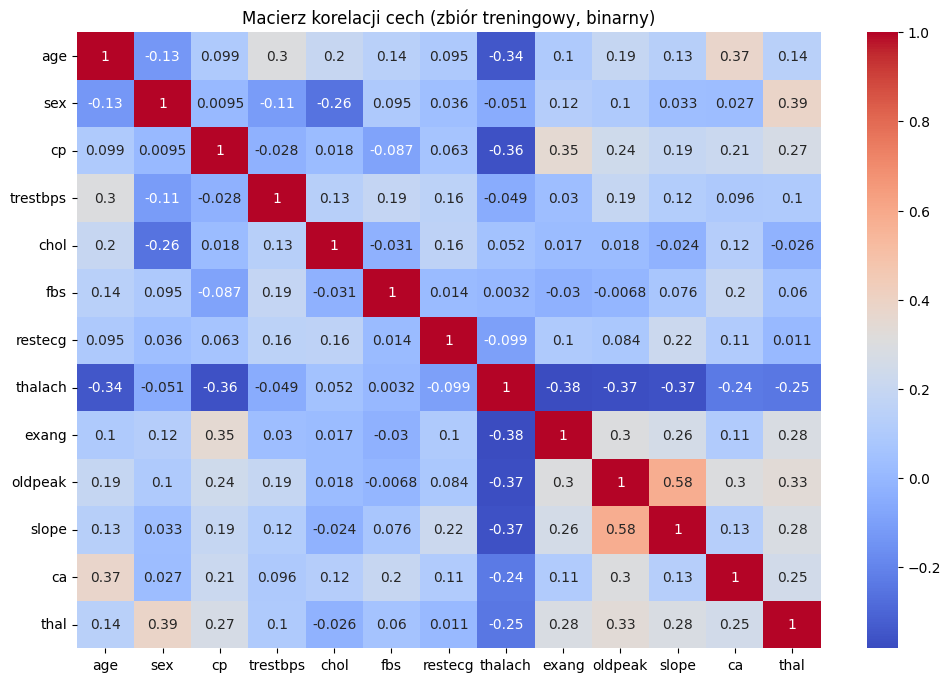

In [ ]:
######################################
# 4. EKSPLORACJA I WIZUALIZACJA
######################################
plt.figure(figsize=(12,8))
sns.heatmap(X_train_bin.corr(), annot=True, cmap="coolwarm")
plt.title("Macierz korelacji cech (zbiór treningowy, binarny)")
plt.show()


In [ ]:
######################################
# 5. STANDARYZACJA
######################################
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)


In [ ]:
######################################
# 6. DEFINICJA I TRENING MODELI
######################################
# 6.1. Logistic Regression – BINARY
model_lr_bin = LogisticRegression(random_state=42)
model_lr_bin.fit(X_train_bin_scaled, y_train_bin)

# 6.2. Logistic Regression – MULTICLASS
model_lr_multi = LogisticRegression(
    random_state=42, multi_class='multinomial', solver='lbfgs'
)
model_lr_multi.fit(X_train_multi_scaled, y_train_multi)

# --- 6.2. SVC (Support Vector Classifier) ---
from sklearn.svm import SVC

# BINARY
model_svc_bin = SVC(probability=True, random_state=42)
model_svc_bin.fit(X_train_bin_scaled, y_train_bin)

# MULTICLASS
model_svc_multi = SVC(probability=True, random_state=42)
model_svc_multi.fit(X_train_multi_scaled, y_train_multi)


# --- 6.3. Decision Tree ---
from sklearn.tree import DecisionTreeClassifier

# BINARY
model_tree_bin = DecisionTreeClassifier(random_state=42)
model_tree_bin.fit(X_train_bin_scaled, y_train_bin)

# MULTICLASS
model_tree_multi = DecisionTreeClassifier(random_state=42)
model_tree_multi.fit(X_train_multi_scaled, y_train_multi)


# --- 6.4. Random Forest ---
from sklearn.ensemble import RandomForestClassifier

# BINARY
model_rf_bin = RandomForestClassifier(random_state=42)
model_rf_bin.fit(X_train_bin_scaled, y_train_bin)

# MULTICLASS
model_rf_multi = RandomForestClassifier(random_state=42)
model_rf_multi.fit(X_train_multi_scaled, y_train_multi)


# --- 6.5. MLP (Multi-Layer Perceptron) ---
from sklearn.neural_network import MLPClassifier

# BINARY
model_mlp_bin = MLPClassifier(max_iter=1000, random_state=42)
model_mlp_bin.fit(X_train_bin_scaled, y_train_bin)

# MULTICLASS
model_mlp_multi = MLPClassifier(max_iter=1000, random_state=42)
model_mlp_multi.fit(X_train_multi_scaled, y_train_multi)


# --- 6.6. (Opcjonalnie) XGBoost ---
# Upewnij się, że masz zainstalowane: !pip install xgboost
from xgboost import XGBClassifier

# BINARY
model_xgb_bin = XGBClassifier(random_state=42, eval_metric='mlogloss')
model_xgb_bin.fit(X_train_bin_scaled, y_train_bin)

# MULTICLASS
model_xgb_multi = XGBClassifier(random_state=42, eval_metric='mlogloss')
model_xgb_multi.fit(X_train_multi_scaled, y_train_multi)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)


=== Ewaluacja: Klasyfikacja Binarna (chore/zdrowe) ===

[WYNIKI] Logistic Regression – Binarna
Accuracy: 0.8533333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        40
           1       0.85      0.83      0.84        35

    accuracy                           0.85        75
   macro avg       0.85      0.85      0.85        75
weighted avg       0.85      0.85      0.85        75


[WYNIKI] SVC – Binarna
Accuracy: 0.8533333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        40
           1       0.88      0.80      0.84        35

    accuracy                           0.85        75
   macro avg       0.86      0.85      0.85        75
weighted avg       0.85      0.85      0.85        75


[WYNIKI] Decision Tree – Binarna
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   supp

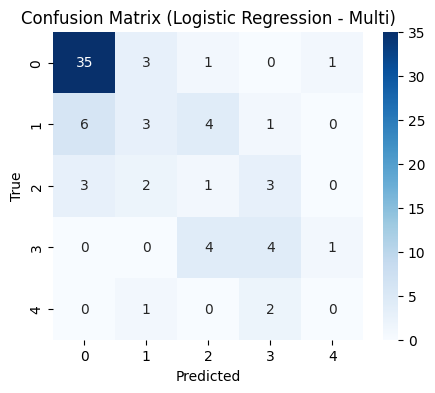


[WYNIKI] SVC – Wieloklasowa
Accuracy: 0.5866666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        40
           1       0.40      0.29      0.33        14
           2       0.08      0.11      0.09         9
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         3

    accuracy                           0.59        75
   macro avg       0.25      0.27      0.26        75
weighted avg       0.50      0.59      0.54        75



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


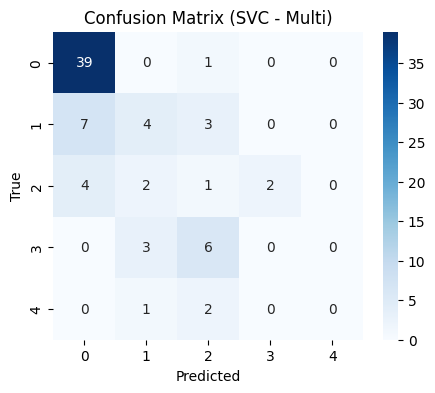


[WYNIKI] Decision Tree – Wieloklasowa
Accuracy: 0.4533333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        40
           1       0.11      0.14      0.12        14
           2       0.33      0.22      0.27         9
           3       0.00      0.00      0.00         9
           4       0.33      0.33      0.33         3

    accuracy                           0.45        75
   macro avg       0.29      0.28      0.28        75
weighted avg       0.43      0.45      0.44        75



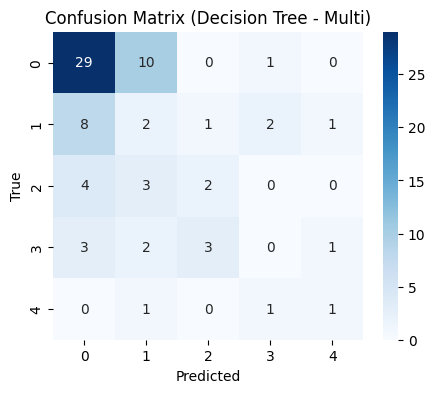


[WYNIKI] Random Forest – Wieloklasowa
Accuracy: 0.5333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        40
           1       0.21      0.21      0.21        14
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         3

    accuracy                           0.53        75
   macro avg       0.19      0.23      0.21        75
weighted avg       0.43      0.53      0.48        75



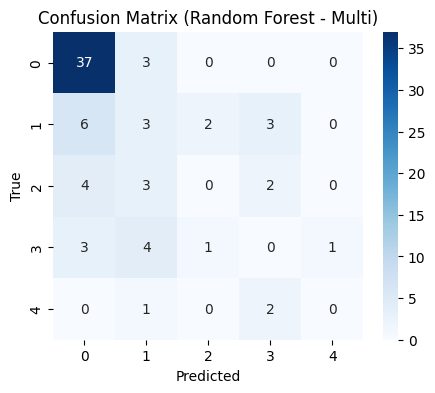


[WYNIKI] MLP – Wieloklasowa
Accuracy: 0.5333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        40
           1       0.22      0.29      0.25        14
           2       0.20      0.11      0.14         9
           3       0.22      0.22      0.22         9
           4       0.00      0.00      0.00         3

    accuracy                           0.53        75
   macro avg       0.29      0.29      0.29        75
weighted avg       0.52      0.53      0.53        75



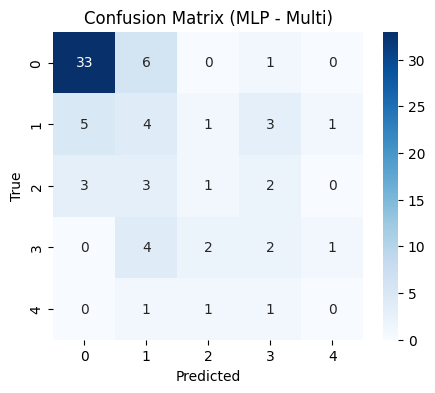


[WYNIKI] XGBoost – Wieloklasowa
Accuracy: 0.5333333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        40
           1       0.19      0.21      0.20        14
           2       0.22      0.22      0.22         9
           3       0.17      0.11      0.13         9
           4       0.00      0.00      0.00         3

    accuracy                           0.53        75
   macro avg       0.29      0.28      0.28        75
weighted avg       0.54      0.53      0.53        75



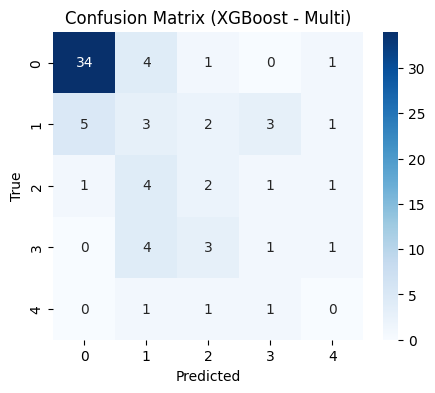

In [ ]:
######################################
# 7. EWALUACJA WSZYSTKICH MODELI
######################################
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 7.1. Lista modeli do klasyfikacji binarnej (0 vs 1)
models_bin = [
    ("Logistic Regression", model_lr_bin),
    ("SVC", model_svc_bin),
    ("Decision Tree", model_tree_bin),
    ("Random Forest", model_rf_bin),
    ("MLP", model_mlp_bin),
    ("XGBoost", model_xgb_bin),
]

print("\n=== Ewaluacja: Klasyfikacja Binarna (chore/zdrowe) ===")
for name, model in models_bin:
    y_pred_bin = model.predict(X_test_bin_scaled)
    acc_bin = accuracy_score(y_test_bin, y_pred_bin)
    print(f"\n[WYNIKI] {name} – Binarna")
    print("Accuracy:", acc_bin)
    print("Classification Report:")
    print(classification_report(y_test_bin, y_pred_bin))

# 7.2. Lista modeli do klasyfikacji wieloklasowej (0–4)
models_multi = [
    ("Logistic Regression", model_lr_multi),
    ("SVC", model_svc_multi),
    ("Decision Tree", model_tree_multi),
    ("Random Forest", model_rf_multi),
    ("MLP", model_mlp_multi),
    ("XGBoost", model_xgb_multi),
]

print("\n=== Ewaluacja: Klasyfikacja Wieloklasowa (0–4) ===")
for name, model in models_multi:
    y_pred_multi = model.predict(X_test_multi_scaled)
    acc_multi = accuracy_score(y_test_multi, y_pred_multi)
    print(f"\n[WYNIKI] {name} – Wieloklasowa")
    print("Accuracy:", acc_multi)
    print("Classification Report:")
    print(classification_report(y_test_multi, y_pred_multi))

    cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_multi, annot=True, cmap="Blues", fmt="g")
    plt.title(f"Confusion Matrix ({name} - Multi)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



=== PORÓWNANIE MODELI – KLASYFIKACJA BINARNA (chore/zdrowe) ===
                 Model  Accuracy
0  Logistic Regression  0.853333
1                  SVC  0.853333
2        Decision Tree  0.760000
3        Random Forest  0.853333
4                  MLP  0.866667
5              XGBoost  0.826667

=== PORÓWNANIE MODELI – KLASYFIKACJA WIELOKLASOWA (0–4) ===
                 Model  Accuracy
0  Logistic Regression  0.573333
1                  SVC  0.586667
2        Decision Tree  0.453333
3        Random Forest  0.533333
4                  MLP  0.533333
5              XGBoost  0.533333


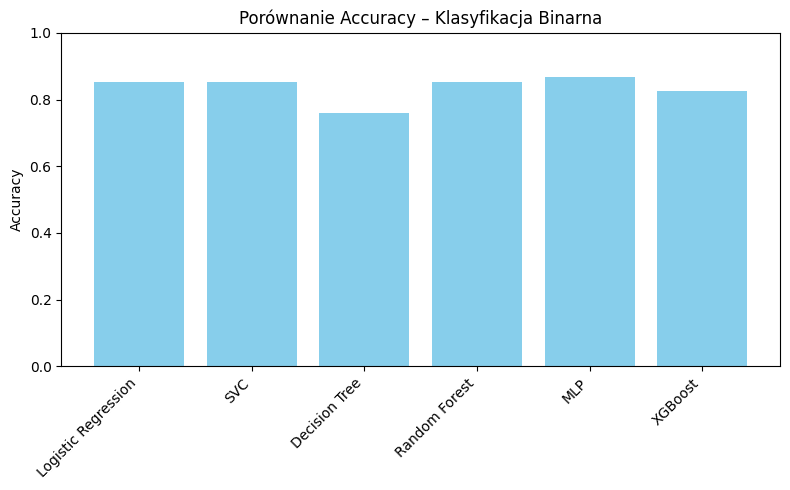

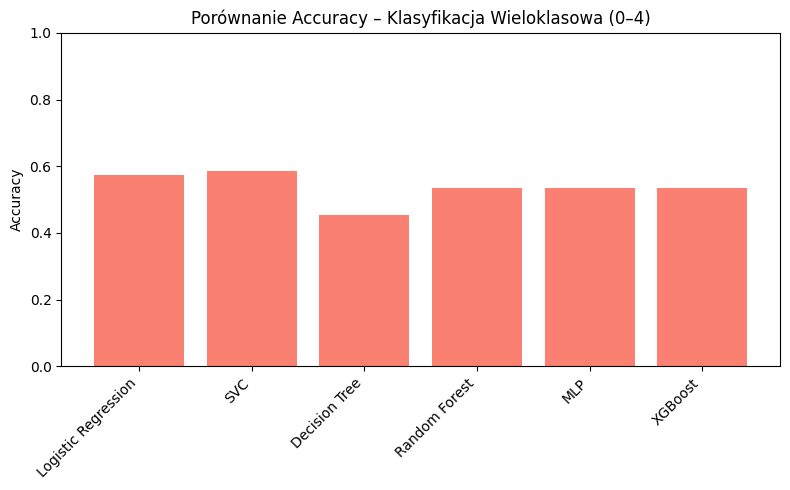

In [ ]:
######################################
# 8. PORÓWNANIE MODELI
######################################
import pandas as pd
import matplotlib.pyplot as plt


# 8.1. Zebranie wyników w listach
results_bin = []
for name, model in models_bin:
    y_pred = model.predict(X_test_bin_scaled)
    acc = accuracy_score(y_test_bin, y_pred)
    results_bin.append((name, acc))

results_multi = []
for name, model in models_multi:
    y_pred = model.predict(X_test_multi_scaled)
    acc = accuracy_score(y_test_multi, y_pred)
    results_multi.append((name, acc))

# 8.2. Konwersja do DataFrame
df_bin = pd.DataFrame(results_bin, columns=["Model", "Accuracy"])
df_multi = pd.DataFrame(results_multi, columns=["Model", "Accuracy"])

# 8.3. Wyświetlenie tabel tekstowych
print("\n=== PORÓWNANIE MODELI – KLASYFIKACJA BINARNA (chore/zdrowe) ===")
print(df_bin)

print("\n=== PORÓWNANIE MODELI – KLASYFIKACJA WIELOKLASOWA (0–4) ===")
print(df_multi)

# 8.4. Wykres słupkowy (binarna)
plt.figure(figsize=(8, 5))
plt.bar(df_bin["Model"], df_bin["Accuracy"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Porównanie Accuracy – Klasyfikacja Binarna")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# 8.5. Wykres słupkowy (wieloklasowa)
plt.figure(figsize=(8, 5))
plt.bar(df_multi["Model"], df_multi["Accuracy"], color='salmon')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Porównanie Accuracy – Klasyfikacja Wieloklasowa (0–4)")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()
